## Sources:
https://github.com/maxbozza/HOG-SVMlight-trainer/blob/master/train_SVMlight.py

https://github.com/aarcosg/object-detector-svm-hog-python


In [1]:
%pip install -q scikit-image scikit-learn imutils
!pwd

Note: you may need to restart the kernel to use updated packages.
/mnt/c/Users/XTI/Desktop/Yüksek Lisans/MSc_Projects/BM5113 - Bilgisayarla Görme/hw2


In [2]:
from src.utensils_data_read import load_data, split_dataset

In [3]:
dataset = load_data(dataset_path="data/all", num_classes=None)
trainX, testX, trainY, testY = split_dataset(dataset, test_size=0.25, random_state=42)

In [4]:
list(zip(trainX, trainY))[:5]

[('data/all/BOTTLE_OPENER/RAW/bottleopenerraw6.JPG', array(0)),
 ('data/all/LADLE/RAW/ladleraw4.JPG', array(8)),
 ('data/all/POTATO_PEELER/RAW/potatopeelerraw16.jpg', array(12)),
 ('data/all/POTATO_PEELER/RAW/potatopeelerraw10.JPG', array(12)),
 ('data/all/TONGS/RAW/tongsraw30.jpg', array(17))]

## 1)
Harris köşe bulma algoritmasını (k = 0.05, W = 7x7 ve köşelilik değerleri üzerinde uygun bir eşik  değeri) ile  çalıştırınız

Köşe bulma  algoritmasını çalıştırmadan evvel gerek görülürse arka plan bilgisini standarda oturtmak için bir ön işleme düşünülebilir.

Harris köşe bulma algoritması farklı ölçeklerde hesaplanıp yerel maksimum noktalarının belirlenmesiyle köşe noktaları ölçekten bağımsız hale getirilebilir.

In [22]:
# https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_corner.html
from skimage.feature import corner_harris, corner_subpix,  corner_peaks
from skimage.io import imread
import numpy as np

for img_path in trainX:
    img = imread(img_path, as_gray=True)
    np.asarray(img, dtype=np.float64)
    print(img.shape)

    corners = corner_peaks(corner_harris(img, k=0.02), min_distance=1, threshold_rel=0.02)
    print(corners.shape)

    corners_subpix = corner_subpix(img, corners, window_size=7)
    print(corners_subpix.shape)
    break

(1536, 2048)
(123, 2)
(123, 2)


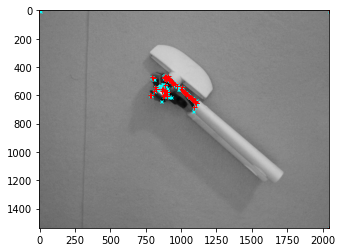

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(corners[:, 1], corners[:, 0], color='cyan', marker='x', linestyle='None', markersize=3)
ax.plot(corners_subpix[:, 1], corners_subpix[:, 0], '+r', markersize=5)
#ax.axis((0, 310, 200, 0))
plt.show()

## 2) 
Belirlenen bu köşe noktaları için tanımlayıcılar oluşturulacaktır.   
Tanımlayıcılar eğimlerin histogramı (Histogram  of  gradients-HoG) yöntemi kullanılarak hesaplanacaktır. 

Bunun için bulunan ilgi noktası koordinatlarını merkeze alan W=32x32 boyutunda pencerelerde çalışılabilir.
1. Burada W toplamda 4x4‘lük 16 hücreye ayrılmaktadır. 
    Bu durumda her bir hücre 8x8 pikselden oluşur. Ardından her bir hücre içerisindeki pikseller için; 
    * açı bilgisi histogram kovasının indeksi; 
    * genlik bilgisi ise bu kovalara atanan değerler olarak kullanılıp eğimlerin histogramı oluşturulacaktır.

    Bu histogramlar ardından genlik değerleri toplamı ile normalize edilecektir.
    
    Böylece toplam 16 hücrede histogramın kova sayısı 8 olacak şekilde açı aralıkları belirlendiğinde,
     her bir ilgi noktası için  16x8=128 uzunluğunda bir tanımlayıcı bulunacaktır.  
  
  
2. Not: Burada farklı renk kanallarına ait genlik ve açı bilgilerinden en yüksek olanının seçilmesiyle kanal sayısı bire indirgenebilir.

In [58]:
from skimage.feature import hog

for corner in corners:
    roi_size = (32, 32)
    roi = img[corner[0]-roi_size[0]//2:corner[0]+roi_size[0]//2, corner[1]-roi_size[1]//2:corner[1]+roi_size[1]//2]

    print(f"roi.shape: {roi.shape}")
    # 8 * 16
    fd, hog_image = hog(roi, orientations=8, pixels_per_cell=(8, 8), visualize=True, feature_vector=True)
    print(hog_image.shape, fd.shape)

    break

roi.shape: (32, 32)
(32, 32) (288,)


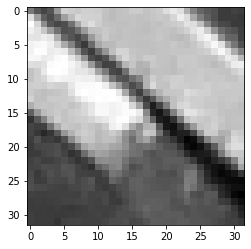

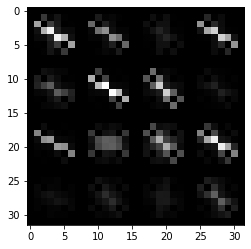

In [59]:
plt.imshow(roi, cmap=plt.cm.gray)
plt.show()
plt.imshow(hog_image, cmap=plt.cm.gray)

## 3) 
Bulunan tanımlayıcılar ilgili sınıfa ait tüm eğitim görüntüleri için uygun etiketlerle bir kenara kaydedilip gerektiğinde test görüntülerini sınıflandırma amacıyla kullanılacaktır. Bunun için tüm test görüntülerinde de benzer tanımlayıcılar çıkarılacaktır. Bir test görüntüsüne ait her bir tanımlayıcı için k-en yakın komşu algoritmasıyla eğitimde belirlenen tanımlayıcı kümelerine olan benzerlik yüzdeleri hesaplanacaktır. k değeri burada 3, 5 veya 7 olarak denenebilir. Test görüntüsü tüm tanımlayıcılar eşlendikten sonra en yüksek yüzdeyi veren sınıfın etiketiyle etiketlenecektir.

## 4) 
Bulunan tanımlayıcılar ilgili sınıfa ait tüm eğitim görüntüleri için uygun etiketlerle bir kenara kaydedilip gerektiğindetest görüntülerini sınıflandırma amacıyla kullanılacaktır. Bunun içintüm test görüntülerinde de benzertanımlayıcılar çıkarılacaktır. Bir test görüntüsüne ait her bir tanımlayıcı için k-en yakın komşu algoritmasıyla eğitimde belirlenen tanımlayıcı kümelerine olan benzerlik yüzdeleri hesaplanacaktır. k değeri burada 3, 5veya 7olarak denenebilir. Test görüntüsü tüm tanımlayıcılareşlendikten  sonra en  yüksek  yüzdeyi  veren  sınıfın  etiketiyle etiketlenecektir.

## Eğitim:
Her bir sınıf için,1.Eğitim görüntüleri içerisinde Harris köşe noktalarını belirle ve her nokta için HoG tanımlayıcılarını hesapla. 2.Bu tanımlayıcıları ilgili sınıfıtemsil etmek için bir dosyada veya veri yapısında sakla.

## Test:
    Test kümesindeki her bir görüntü için,
        * 1. Harris köşe noktalarını belirle ve bunların HoG tanımlayıcılarını hesapla.  
        * 2. Her  bir  tanımlayıcının  eğitim  sürecinde  kaydedilen  farklı  sınıflara  ait tanımlayıcılara  olan  mesafesini hesapla.    
            En  düşük  mesafeye  sahip  k tanımlayıcıyı  belirledikten  sonra  ilgili özelliğin hangi  sınıfı  temsil  ediyor olduğuna karar ver. 
            Buna göre ilgili sınıfa ait olma sayacını bir arttır.   
    Not: Eğer bir özelliğin en yakın eşlemeleri çok farklı sınıflara ait oluyorsa bu durum  belirsizlik  (ambiguity)  olarak  değerlendirilip  ilgili  özellik  dikkate alınmayabilir.Alternatif   olarak   ken  yakın  komşu  içerisinde  hangi  sınıf etiketleri oluşmuşsa bu etiketler test örneğinin ilgili sınıfa ait olma olasılığını arttırmada kullanılabilir.3.Nihayette  ilgili  test görüntüsünün hangi sınıfa ait olma olasılığı daha yüksek ise görüntüyü o sınıfın etiketiyle etiketlendir.